# Step 1 Import packages and data sets

In [25]:
from fastai.imports import *
import warnings
warnings.filterwarnings("ignore") #ignore warnings

import pandas as pd 
import numpy as np 
import random as rnd 

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# Step 2 Describe and process data

In [26]:
print(train_df.columns.values)
print(round(train_df.describe(percentiles=[0.25, 0.50, 0.75, 0.99, 1.00]), 2))

#Pclass: class of passenger
#Sibsp: amount of siblings on the ship
#Parch: amount of parents or children on the ship

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
       PassengerId  Survived  Pclass     Age   SibSp   Parch    Fare
count       891.00    891.00  891.00  714.00  891.00  891.00  891.00
mean        446.00      0.38    2.31   29.70    0.52    0.38   32.20
std         257.35      0.49    0.84   14.53    1.10    0.81   49.69
min           1.00      0.00    1.00    0.42    0.00    0.00    0.00
25%         223.50      0.00    2.00   20.12    0.00    0.00    7.91
50%         446.00      0.00    3.00   28.00    0.00    0.00   14.45
75%         668.50      1.00    3.00   38.00    1.00    0.00   31.00
99%         882.10      1.00    3.00   65.87    5.00    4.00  249.01
100%        891.00      1.00    3.00   80.00    8.00    6.00  512.33
max         891.00      1.00    3.00   80.00    8.00    6.00  512.33


In [27]:
train_df.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [28]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [29]:
conts=['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
modes = train_df.mode().iloc[0]

def fill_na(df): # Define a function to process the data
    df['Fare'] = df.Fare.fillna(0) # Fill any missing values in the 'Fare' column with 0
    df['LogFare'] = np.log1p(df['Fare']) # Create a new column 'LogFare' which is the logarithm (plus 1) of the 'Fare' column to handle cases where Fare might be 0
    
    imputer = KNNImputer(n_neighbors=2)
    df[conts] = imputer.fit_transform(df[conts])# Fill missing values in other columns with K-Nearest Neighbors Imputation
    
    df.fillna(modes, inplace=True) # Fill any missing values in other columns with pre-calculated modes (commonly occurring values)
    
    df['Embarked'] = pd.Categorical(df.Embarked) # Convert the 'Embarked' column to a categorical datatype, facilitating encoding for modeling
    df['Sex'] = pd.Categorical(df.Sex) # Convert the 'Sex' column to a categorical datatype

fill_na(train_df)
fill_na(test_df)

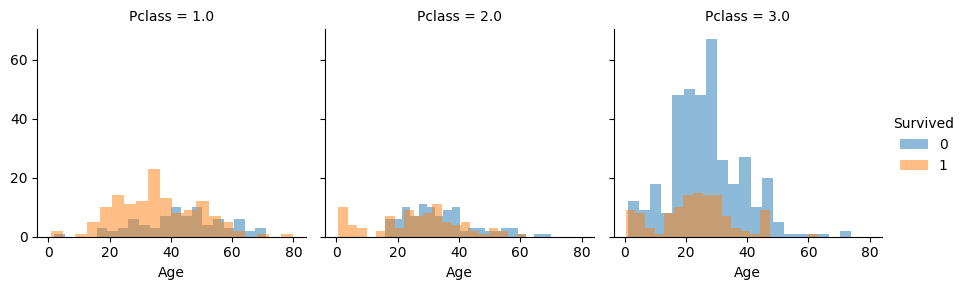

In [30]:
grid_pclass = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid_pclass.map(plt.hist, 'Age', alpha=0.5, bins=20).add_legend()
# Notice that age and pclass are significantly related to surviced.

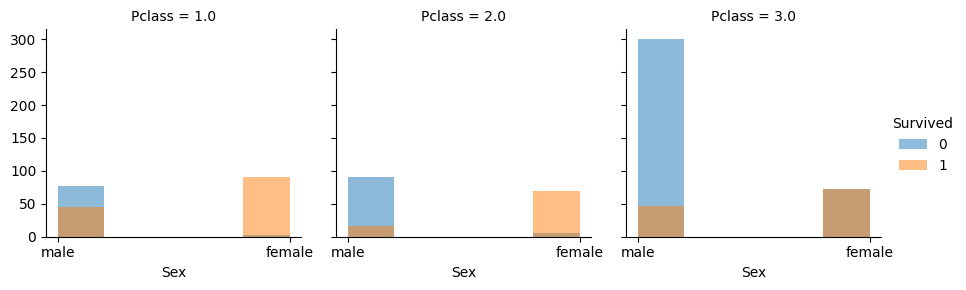

In [31]:
grid_pclass = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid_pclass.map(plt.hist, 'Sex', alpha=0.5, bins=5).add_legend()
# And also sex

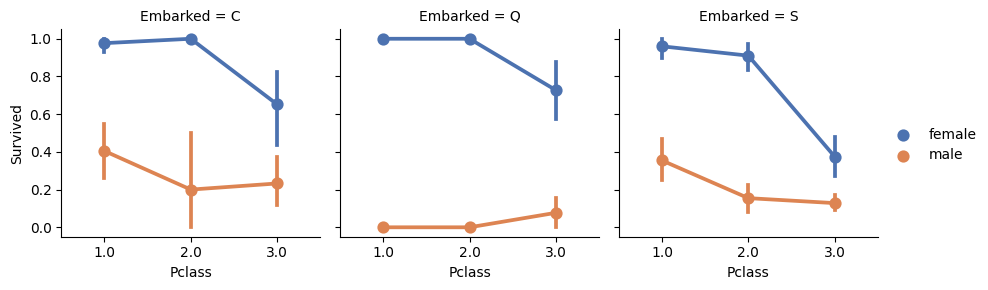

In [32]:
grid_embark = sns.FacetGrid(train_df, col='Embarked')
grid_embark.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep').add_legend()
# And embarked

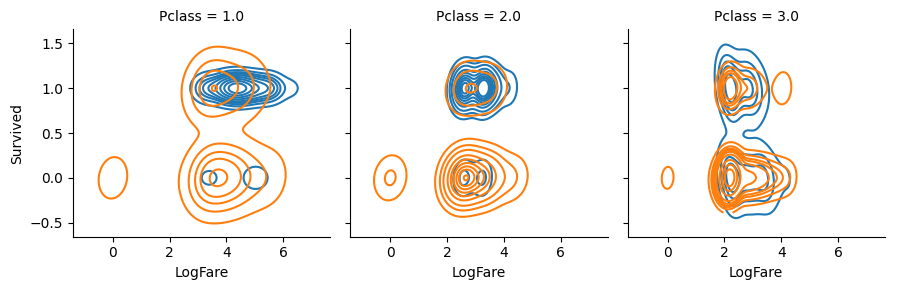

In [33]:
grid_logfare = sns.FacetGrid(train_df, col='Pclass')
grid_logfare.map(sns.kdeplot, 'LogFare', 'Survived', 'Sex').add_legend()
# And fare

In [34]:
train_df['Name'].head(10)
#Notice that names contain titles, which might be a useful feature

0                                Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Thayer)
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [35]:
combine = [train_df, test_df]

for data in combine:
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex']).sort_values(by='female', ascending=False)

Sex,female,male
Title,,
Miss,182,0
Mrs,125,0
Mlle,2,0
Mme,1,0
Countess,1,0
Dr,1,6
Ms,1,0
Lady,1,0
Capt,0,1


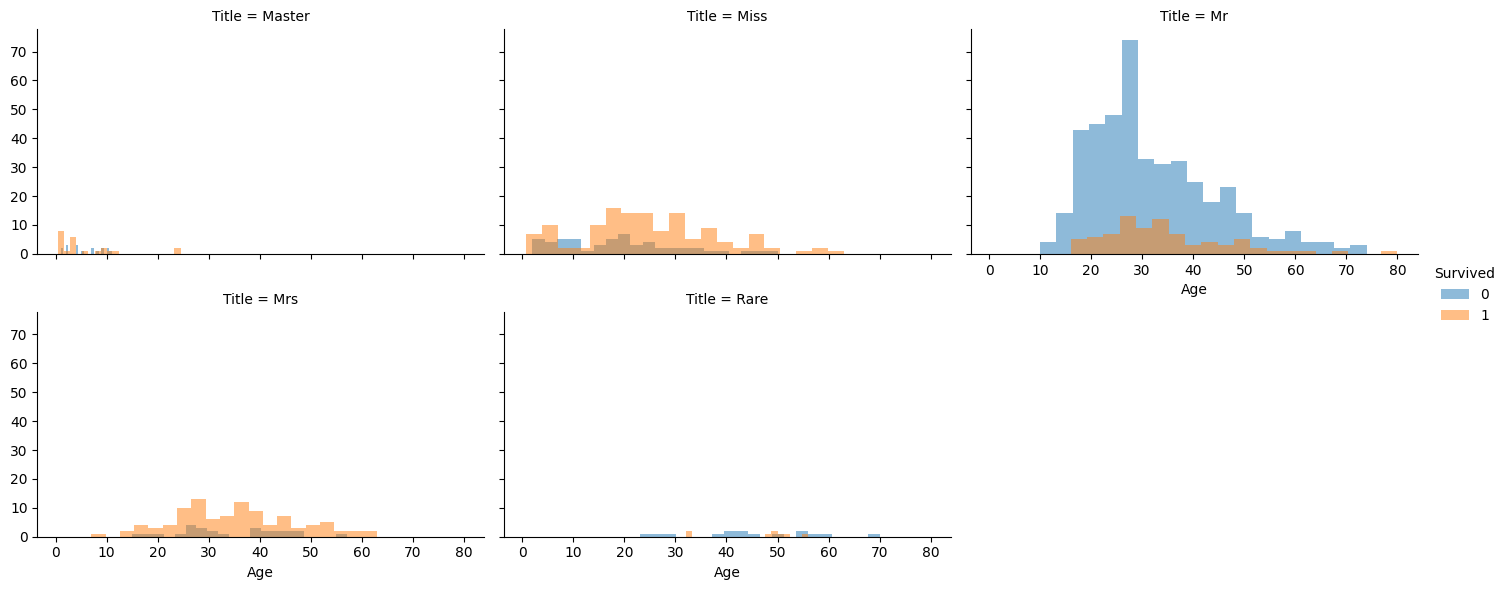

In [36]:
#Combine the rare features
for data in combine:
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare') 
    data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

train_df['Title'] = pd.Categorical(train_df.Title) # Convert the 'Title' column to a categorical datatype
test_df['Title'] = pd.Categorical(test_df.Title)

grid = sns.FacetGrid(train_df, col='Title', hue='Survived', col_wrap=3, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20).add_legend()
#title is also a significant feature

In [37]:
for data in combine:
    data['IsAlone'] = 0 #who had sibling, parent or children
    data.loc[data['SibSp'] + data['Parch'] == 0, 'IsAlone'] =1 #who did not
    
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()
#Having family or not is another significant feature 

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [38]:
cats = ['Embarked', 'Sex', 'Title']
conts = ['Age', 'Pclass', 'LogFare', 'IsAlone']
dep = 'Survived'

train_df['Embarked'] = pd.Categorical(train_df.Embarked) # Convert the 'Embarked' column to a categorical datatype, facilitating encoding for modeling
train_df['Sex'] = pd.Categorical(train_df.Sex) # Convert 'Sex'
train_df['Title'] = pd.Categorical(train_df.Title) # Convert 'Title'

np.random.seed(6100)
trn_df,val_df = train_test_split(train_df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [44]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

In [45]:
trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

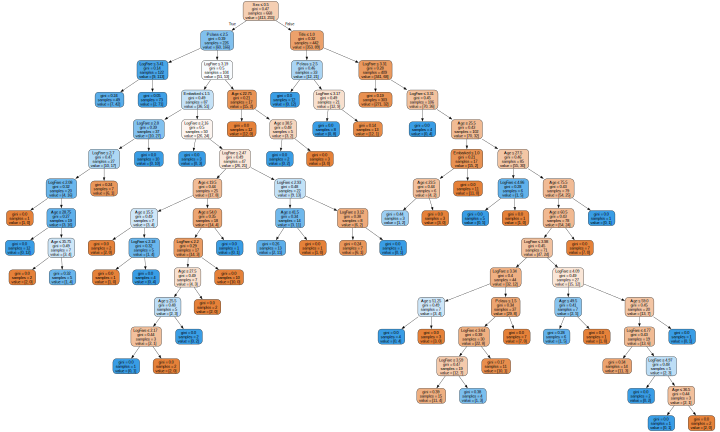

In [59]:
m = DecisionTreeClassifier(max_leaf_nodes=50).fit(trn_xs, trn_y);

import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, trn_xs, size=10)

In [60]:
mean_absolute_error(val_y, m.predict(val_xs))

0.13004484304932734

In [55]:
test_df['Embarked'] = pd.Categorical(test_df.Embarked) # Convert the 'Embarked' column to a categorical datatype, facilitating encoding for modeling
test_df['Sex'] = pd.Categorical(test_df.Sex) # Convert 'Sex'
test_df['Title'] = pd.Categorical(test_df.Title) # Convert 'Title'
test_df[cats] = test_df[cats].apply(lambda x: x.cat.codes)
tst_xs,tst_y = xs_y(test_df)

In [56]:
def subm(preds, suff):
    test_df['Survived'] = m.predict(tst_xs)
    sub_df = test_df[['PassengerId','Survived']]
    sub_df.to_csv(f'submission.csv', index=False)

subm(m.predict(tst_xs), 'tree')